# M4101, La malédiction de la dimensionalité
### Cedric Chauve, cedric.chauve@sfu.ca

## Introduction

Le but de ce calepin est d'introduire plusieurs éléments importants pour ce TP sur la classification :
- la notion de classification binaire supervisée,
- l'algorithme de classification KNN,
- les métriques de qualité d'un classifieur,
- la notion de "malédiction de la dimensionalité",
- une technique de réduction de la dimensionalité, l'analyse en composantes principales.

Les méthodes d'IA que nous allons utiliser sont implémentées dans la bibliothèque <a href="https://scikit-learn.org/stable/">scikit-learn (sklearn)</a>. 

In [1]:
# numpy
import numpy as np

# Scikit-learn
from sklearn import neighbors # Bibliotheque contenant l'algorithme KNN
from sklearn import metrics   # Metriques mesuran les performances d'algorithme de classification

# Matplotlib et seaborn pour les figures
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Pandas pour manipuler des tableaux sous la forme de "data frames"
import pandas as pd

# Préambule : classification binaire et dimensionalité

Le but de la classification binaire consiste à séparer un jeu de données en deux classes, qu'on appelle **classe 0** et **classe 1**. On peut penser par exemple à un groupe de patients atteints d'une maladie ayant ayant deux formes légèrement différentes nécessitant des traitements différents. 

Dans ce contexte, on voudrait se baser sur un jeu de données d'apprentissage, par exemple les données médicales d'un ensemble de patients pour lesquelles la forme de la maladie est connue, pour mettre au point un **classifieur**, c'est-à-dire un programme qui, étant donné les données médicales d'un nouveau patient peut déterminer à quelle classe il appartient, donc quel traitement il devra suivre.

Dans l'exemple que nous allons suivre dans ce calepin, on suppose que les données médicales sont obtenues par analyse génétiques et correspondent à l'expression d'un certain nombres de gènes connus pour être possiblement liés à la maladie. Il importe peu ici de savoir précisément ce qu'est l'expression d'un gène (il s'agit d'une mesure de la quantité de protéines synthétisées par le gène) : pour notre problème de classification, les données associées à  un patient forment un vecteur de **d** nombres, correspondant aux **d** gènes mesurés.

Le nombre **d** de gènes mesurés, c'est-a-dire de caractéristiques associées à chaque patient est appelé la **dimensionalité** du problème de classification. Dans ce calepin, on veut démontrer que plus la dimensionalité augmente (i.e. plus on mesure de gènes, en prenant le risque que certains ne soient en fait pas liés à la maladie et donc n'approte pas d'information mais du **bruit** qui dilue le signal de classification), plus le problème de classification devient difficile et les performance des algorithmes de classifications se dégradent.

## Génération de données propres.

Supposons que les deux formes de la maladie que nous considérons dépendent de seulement deux gènes, appelons-les gènes **A** et **B** : les malades de la classe 0 sont caractérisés par une expression normale du gène A (autour de 1) et une expression plutot forte du gène B (autour de 1.5), alors que les malades de la classe 1 sont au contraire caractérisés par une expression normale du gène B (autour de 1) et une expression plutot forte du gène A (autour de 1.5). Supposons de plus que nous avons un jeu de données de **n=1000** patients, avec 500 patients dans chaque classe.

Comme chaque patient est caractérisé par deux valeurs numériques (expression de deux gènes), on peut représenter un patient par un point dans le plan, l'abscisse étant l'expression du gène A et l'ordonnée  l'expression du gène B.

Pour générer des données simulées relativement propres, on veut générer une matrice **nxd=1000x2** de nombres, chaque ligne l'expression des deux gènes pour un patient, et on veut que les points dans le plan correspondant forment deux groupes, un groupe dans le coin haut gauche du plan (patients de la classe 0) et un groupe dans le coin bas droite (patients de la classe 1).

On note **X** la matrice ainsi obtenue.
On définit aussi un vecteur **y** binaire associant à chacun des 1000 points sa classe (0 ou 1).
Finalement on va s'assurer que les lignes de la matrice sont réordonnées aléatoirement pour éviter d'avoir tous les patients d'une classe formant un bloc de la matrice **X**.

Les données ainsi générées sont des données **bi-dimensionnelles** vu que l'on considère seulement deux dimensions (l'expression des deux gènes A et B).

In [2]:
# Fonctions auxiliaires

# Ajout de bruit à une donnée vectorielle p de dimension arbitraire
# epsilon indique le niveau de bruit a ajouter : on ajoute a chaque entree
# du vecteur p un nombre aleatoire compris entre -epsilon/2 et epsilon/2
def bruiter(p,epsilon):
    d = len(p) # dimensionalite de p
    return([p[d]+np.random.random()*epsilon-epsilon/2.0 for d in range(d)])

# Visualisation de données en deux dimensions
# X     = matrice de donnees, de taille nx2
# y     = vecteur binaire indiquant les classes de chaque donnee, de taille nx1
# titre = titre de la figure
def scatter_2D(X,y,titre):
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)
    plt.tight_layout()
    plt.title(titre)
    plt.show()

In [3]:
# Génération de données bi-dimensionnelles relativement propres

# Nombre d'éléments par classe
N = 500
# Niveau de bruit
epsilon = 0.7

# Classe  0
X0 = [bruiter([1.5,1],epsilon) for i in range(N)]
y0 = [0 for i in range(N)]
# Classe 1
X1 = [bruiter([1,1.5],epsilon) for i in range(N)]
y1 = [1 for i in range(N)]
# On fusionne les données des deux classes
X = np.array(X0+X1)
y = np.array(y0+y1)
# On mélange les données
permutation = np.random.permutation(2*N)
X = X[permutation]
y = y[permutation]

Visualisons ces données maintenant. On observe dans la figure ci-dessous deux groupes de points, les points bleus (représentant les données des patients de la classe 0) et les points rouges (représentant les données des patients de la classe 1) qui sont relativement bien séparés, bien qu'il y'ait un chevauchement au milieu de la figure. Il s'agit de la situation typique avec ce genre de données, le chevauchement de points rouges et bleus au milieu de la figure correspondant par exemple à des patients atypiques ou à des erreurs de diagnostique. Il est important de réaliser qu'en classification, on retrouve toujours ce type de phénomènes de bruit dans les données d'apprentissage. Néammoins, la séparation visible entre les deux groupes de points peut nous faire dire que nos données sont assez propres.

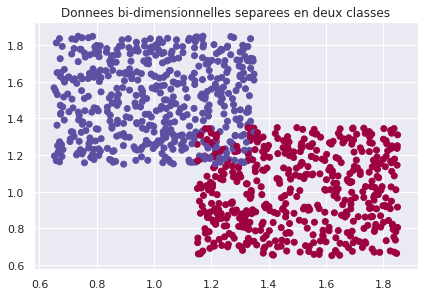

In [4]:
scatter_2D(X,y,'Donnees bi-dimensionnelles separees en deux classes')

# Classification avec l'algorithme KNN

On veut maintenant utiliser notre jeu de données d'apprentissage pour développer un classifieur permettant de classifier un nouveau patient en classe 0 ou 1 selon ses données génétiques. 

Pour cela nous allons utiliser l'algorithme de classificastion KNN (K-Nearest Neighbours, les K plus proches voisins). Le principe de cet algorithme est très simple : 
- on suppose qu'on a un jeu de données de patients **X** pour lesquels les données génétiques et la classe sont connues,
- on fixe un paramètre **k** (un nombre entier positif, impair),
- étant donné un nouveau patient **p**
  - on calcule la distance de **p** à tous les patients de **X**,
  - on garde les **k** patients de **X** les plus proches de **p**,
  - on assigne **p** à la classe majoritaire parmi ces **k** patients.
  
Dans notre exemple courant, comme chaque patient est représenté par deux coordonnées, la notion de distance est la distance euclidienne classique définie par
$$d((x,y),(x',y')) = \sqrt{(x-x')^2+(y-y')^2}.$$

L'algorithme KNN est implémenté dans le module *neighbours* de la bibliothèque *scikit-learn*. Pour l'utiliser on va partager notre jeu de données d'apprentissage **X, y** en deux ensembles, chacun de 500 patients, un jeu pour entrainer le classifieur (**X_train, y_train**) et un jeu pour le tester (**X_test, y_test**). On va utiliser la valeur de **k** par défaut qui vaut 5.

In [5]:
# Classification avec KNN; on ne retourne que les statistiques exactitude et F1

def clf_knn_train(X,y):
    # Creation d'un classifieur KNN avec parameters par defaut
    clf_knn = neighbors.KNeighborsClassifier()
    # Entrainement du classifieur avec les donnees d'entrainement
    classifieur = clf_knn.fit(X,y)
    return(classifieur)

def clf_knn_test(clf,X,y):
    # Application du classifieur entraine sur les donnees de test
    predictions = clf.predict(X)
    # Calcul de deux metriques de performances du classifieur : exactitude et score F1
    F1          = metrics.f1_score(y, predictions)
    exactitude  = metrics.accuracy_score(y, predictions)
    # On renvoie les deux statistiques exactitute et score F1
    return({'F1':round(F1,4),'exactitude':round(exactitude,4)})

def clf_knn(X,y):
    # Partage des donnees en donnees d'apprentissage et donnees de test
    X_train = X[0:N,:]
    y_train = y[0:N]
    X_test  = X[N:,:]
    y_test  = y[N:]
    # Entrainement du classifieur
    classifieur = clf_knn_train(X_train,y_train)
    # Test du classifieur
    resultats   = clf_knn_test(classifieur,X_test,y_test)
    return(resultats)

Avant d'essayer ce classifieur, prenons un peu de temps pour définir précisément ce que sont ces deux statistiques.

Prenons un patient *p* du jeu de test : on connait sa vraie classe qu'on note *v(p)* et on a la classe prédite par le classifieur qu'on note *k(p)*. On a donc 4 cas
- *v(p)=k(p)=1* : on dit que *p* est un Vrai Positif (TP pour True Positive en anglais),
- *v(p)=k(p)=0* : *p* est un Vrai Négatif (TN),
- *v(p)=1, k(p)=0* : *p* est un Faux Négatif (FN),
- *v(p)=0, k(p)=1* : *p* est un Faux Positif (FP). 

On note *TP* (respectivement *TN*, *FN*, *FP*) le nombre de Vrais Positifs (Vrai Négatifs, Faux Négatifs, Faux Positifs) pour tout le jeu de tests.

Si on a *N* patients dans notre jeu de test, on définit deux statistiques du classifieur :
- la précision, $Prec = TP/(TP+FP)$ mesure le ratio d'erreurs de classification dans la classe 1 (une précision de 1 indique qu'on n'a aucun Faux Positif),
- le rappel (Recall en anglais), $Rec = TP/(TP+FN)$ mesure le ratio de patients de la classe 1 qui ont été incorrectement classifiés en classe 0,
- le score F1 est défini par $F_1 = 2 (Prec\times Rec)/(Prec+Rec)$, là encore un score F1 de 1 indique une classification parfaite (car $Prec=Rec=1$).

On peut noter ques ces définitions sont centrées sur la classe 1, et ne sont donc pas symétriques (si on inverse la classe de chaque patient, on obtient des scores différents). Si on a un jeu de données équilibré en termes de nombre de patients de classe 0 et de classe 1, cela ne pose pas de problème, mais cela n'est pas toujours le cas. 

Pour éviter ce problème on utilise aussi le score d'*exactitude* défini par $E = (TP+TN)/N$ qui mesure le ratio d'erreurs de classification.

On peut maintenant tester notre classifieur.

In [6]:
KNN_2D = clf_knn(X,y)
print('Exactitude du classifieur KNN : '+str(KNN_2D['exactitude']))
print('Score F1 du classifieur KNN : '+str(KNN_2D['F1']))

Exactitude du classifieur KNN : 0.958
Score F1 du classifieur KNN : 0.9579


On observe une exactitude et un score F1 de l'ordre de 96%, donc des valeurs plutot élevées et le classifieur marche bien. Si on veut explorer d'où proviennent les erreurs, elles proviennent des patients dont la représentation dans la figure est dans la partie où points bleus et rouges se chevauchent, comme on pouvait s'y attendre.

Pour conclure cette première partie, on peut voir que dans le cas où on connait les deux gènes impliqués dans la différentiation des deux formes de la maladie, on peut obtenir un classifieur ayant de très bonnes performances.

On va se placer maintenant dans un cadre plus réaliste et dans lequel on ne connait pas avec précision quels gènes impliqués dans la différentiation des deux formes de la maladie, mais on a une liste de gènes candidats.

# Ajout de bruit diluant le signal de classification

On suppose donc qu'on a une liste de **d (>=2)** gènes potentiellement impliqués dans la différentiation des deux formes de la maladie, qui incluent les deux vrais gènes encodant du signal de classification (les gènes A et B), plus un nombre **d-2** de gènes ayant en fait une expression moyenne (sur la population de patients) normale (autour de 1).

On va donc augmenter notre matrice **X** par **d-2** nouvelles colonnes, de sorte que pour chaque patient, la valeur dans les nouvelles colonnes est un nombre choisi aléatoirement (donc sans lien avec la maldie en question) dans l'intervalle [0.5,1.5], ce qui nous donnera une moyenne de 1 sur les 1000 patients de nos données, avec là encore une variation correspondant à la diversité entre patients et de possibles erreurs de mesure de l'expression des gènes. On aura donc des données en dimension **d>=2** et on va observer que plus on ajoute des dimensions ne contenant aucun signal de classification, plus les performances d'un classifieur KNN diminuent.

Pour observer l'impact de la dimensionalité (le nombre de dimensions) on va ajouter de 1 à 20 extra dimensions à notre matrice **XX**. Il s'agit d'un nombre tout à fait réaliste, si on sait que le génome humain contient plus de 20,000 gènes. 

In [7]:
# Ajout d'une dimension à un jeu de données en générant, pour chaque donnée
# une coordonnée supplémentaire de valeur attendue 1 comprise dans l'intervalle
# [1-delta/2,1+delta/2]
def ajouter_dimension(X,delta):
    resX = np.array([np.append(p, 1+(np.random.random()-0.5)*delta) for p in X])
    return(resX)

In [8]:
X_ExtraDim  = {0:X}
maxExtraDim = 20
for nd in range(1,maxExtraDim+1):
    X_ExtraDim[nd] = ajouter_dimension(X_ExtraDim[nd-1],1.0)

On va maintenant utiliser exactement la même approche pour créer un classifieur KNN.

In [9]:
# Sans dimension additionelle
KNN_XX = {0:clf_knn(X_ExtraDim[0],y)}
print('Classification KNN sans extra dimension : exactitude='+str(KNN_XX[0]['exactitude'])+'\tF1='+str(KNN_XX[0]['F1']))
# En ajoutant de nouvelles dimensions ne contenant aucun signal de classification
for nd in range(1,maxExtraDim+1):
    KNN_XX[nd] = clf_knn(X_ExtraDim[nd],y)
    print('Classification KNN avec '+str(nd)+' extra dimensions aléatoires : exactitude='+str(KNN_XX[nd]['exactitude'])+'\tF1='+str(KNN_XX[nd]['F1']))

Classification KNN sans extra dimension : exactitude=0.958	F1=0.9579
Classification KNN avec 1 extra dimensions aléatoires : exactitude=0.952	F1=0.9518
Classification KNN avec 2 extra dimensions aléatoires : exactitude=0.948	F1=0.9484
Classification KNN avec 3 extra dimensions aléatoires : exactitude=0.932	F1=0.9323
Classification KNN avec 4 extra dimensions aléatoires : exactitude=0.932	F1=0.9328
Classification KNN avec 5 extra dimensions aléatoires : exactitude=0.94	F1=0.9405
Classification KNN avec 6 extra dimensions aléatoires : exactitude=0.938	F1=0.9391
Classification KNN avec 7 extra dimensions aléatoires : exactitude=0.936	F1=0.936
Classification KNN avec 8 extra dimensions aléatoires : exactitude=0.928	F1=0.9283
Classification KNN avec 9 extra dimensions aléatoires : exactitude=0.928	F1=0.9268
Classification KNN avec 10 extra dimensions aléatoires : exactitude=0.91	F1=0.9091
Classification KNN avec 11 extra dimensions aléatoires : exactitude=0.894	F1=0.8907
Classification KNN 

On observe une tendance claire de diminution des performances du classifieur avec l'augmentation du nombre de dimensions. Au début, lorsque l'on ajoute une poignée de nouvelles dimensions, l'algorithme KNN continue à être performant (exactitude et score F1 aux alentours de 95%) mais à partir de 6 nouvelles dimensions, les performances chutent assez vite, pour descendre aux alentours de 85% avec 20 dimensions supplémentaires. Il s'agit d'un taux d'erreurs de classification de 15% environ, ce qui est assez élevé.

On a là une illustration de la "malédiction de la dimensionalité" ("curse of dimensionality" en anglais) qui correspond au fait que plus on essaie de classifier des objets définis par un vacteur de caractéristiques de grande dimension, plus on dilue le signal de classification et il devient difficile de le détecter.

Pour illustrer cette absence de signal de classification dans les dimensions ajoutées à nos données, on utilise la fonction *pairplot* de la biliothèque de visualisation *seaborn* qui nous permet la séparation de nos deux types de patients (classe 0 et classe 1) si on ne prend en compte que deux dimensions. Pour des raisons de visualisation, on se contente de regarder toute paire de dimensions prises parmi les 7 premières (incluant donc les dimensions correspondant aux gènes A et B.

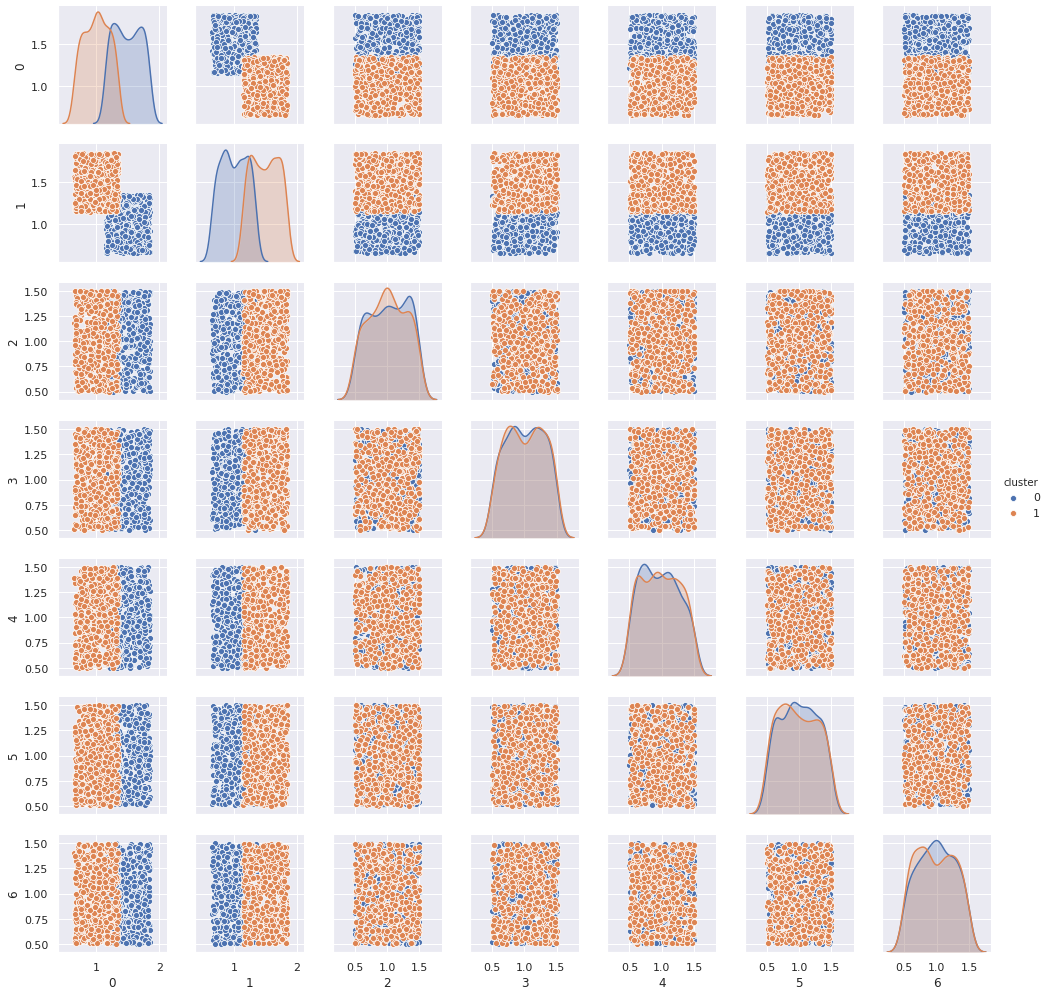

In [10]:
# Scatter plots pour un sous-ensemble de paires de dimensions.
# On se fixe un nombre de dimensions à prendre en comte (ici les 7 premières) et pour chaque 
# paire de dimensions, on génère un scatter plot de nos 1000 points coloriés selon leur cluster.

nbDim = 7
XX_df = pd.DataFrame(X_ExtraDim[nbDim])
XX_df['cluster']  = y
sns.pairplot(XX_df, hue='cluster', vars=range(nbDim), height=2);

On retrouve bien une bonne séparation quand on prend en compte les deux premières dimensions (les gènes A et B) que l'on perd du moment qu'on considère une autre dimension (qui, par construction utilisant des nombres aléatoires, ne contient aucun signal permettant de séparer les deux classes de patients). 

La diagonale de la figure ci-dessus montre la séparation entre les deux classes pour chaque dimension (bonne pour les deux premières, inexistante pour les 5 suivantes).

Hors de la diagonale, chaque graphe représente chaque patient par deux coordonnées (une par dimension), et on observe une absence de séparation.

# Analyse en composantes principales

Nous nous trouvons donc dans la situation où nous voulons développer un classifieur à partir de données dont on suppose que la plupart des dimensions sont non-informatives, mais on en sait pas quelles dimensions de nos données contiennent le signal de classification. De plus, à partir de données en plus de deux dimensions, on ne peut même pas représenter graphiquement les patients pour voir si on observe une bonne séparation en deux classes.

Une approche classique pour régler ce type de problème consiste à plonger nos données dans un espace de dimension réduite. Nous allons illustrer cette approche avec la méthode très utilisée de l'Analyse en Composantes Principales (ACP, PCA en anglais pour "Principal Components Analysis).

On ne va pas décrire la méthode en détail ici, un autre calepin y est dédié. Mais le principe est assez simple. 
- On note **d** la dimension des données de départ. 
- A partir de nos données d'apprentissage **X_train** (données de *n=500* patients), on va calculer une matrice **P** de *changement de base*, c'est-à-dire une matrice *dxd* vu que nos données de départ sont dans un espace à *d* dimensions.
- On utilise cette matrice **P** pour transformer **X_train** en **X_train_acp = P x X_train** (produit de matrices classiques) et  **X_test** en **X_test_acp = P x X_test**, ce qui donne deux nouvelles matrices de taille **n x d**. Pour le moment on n'a donc pas réduit la dimensionalité de notre problème de classification.
- A partir de nos données d'apprentissage **X_train** (données de *n=500* patients), on va calculer une matrice **P** de *changement de base*, c'est-à-dire une matrice *dxd* vu que nos données de départ sont dans un espace à *d* dimensions.
- On prend ensuite les deux premières colonnes de **X_train_acp** pour entrainer un classifieur KNN que l'on teste avec la réduction de **X_test_acp**  ses deux premières colonnes; on travaille donc de nouveau avec des données en deux dimensions.

On implémente cette approche dans le code ci-dessous, où on ajoute aussi une option permettant de visualiser la séparation des patients des deux classes pour les données d'apprentissage et les donnée de test.

In [11]:
# On importe le module scikit-learn permettant d'effectuer une ACP
from sklearn.decomposition import PCA

# Visualisation de données en deux dimensions
# X     = matrice de donnees, de taille nx2
# y     = vecteur binaire indiquant les classes de chaque donnee, de taille nx1
# titre = titre de la figure
def scatter_2D_train_test(X_train,y_train,X_test,y_test):
    plt.figure(figsize=(7, 3))
    plt.subplot(121)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Spectral)
    plt.title('X_train')
    plt.subplot(122)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.Spectral)
    plt.title('X_test')
    plt.tight_layout()
    plt.show()

# Classification KNN avec ACP
def clf_knn_acp(X,y,show_data=False):
    # Partage des donnees en donnees d'apprentissage et donnees de test
    X_train = X[0:N,:]
    y_train = y[0:N]
    X_test  = X[N:,:]
    y_test  = y[N:]
    # On instancie un objet permettant d'effectuer une ACP en deux dimensions
    red_ACP2  = PCA(n_components=2)
    # On calcule la matrice de changement de base et on transforme X_train en X_train_acp
    X_train_acp = red_ACP2.fit_transform(X_train)
    # On transforme maintenant X_test
    X_test_acp  = red_ACP2.transform(X_test)
    if show_data:
        scatter_2D_train_test(X_train_acp,y_train,X_test_acp,y_test)
    # Entrainement du classifieur
    classifieur = clf_knn_train(X_train_acp,y_train)
    # Test du classifieur
    resultats   = clf_knn_test(classifieur,X_test_acp,y_test)
    return(resultats)

On teste l'approche basée sur une réduction ACP en deux dimensions avant d'entrainer un classifieur KNN et de le tester.

In [12]:
# Sans dimension additionelle
KNN_XX_acp = {0:clf_knn_acp(X_ExtraDim[0],y)}
print('Classification KNN+ACP sans extra dimension : exactitude='+str(KNN_XX_acp[0]['exactitude'])+'\tF1='+str(KNN_XX_acp[0]['F1']))
# En ajoutant de nouvelles dimensions ne contenant aucun signal de classification
for nd in range(1,maxExtraDim+1):
    KNN_XX_acp[nd] = clf_knn_acp(X_ExtraDim[nd],y)
    print('Classification KNN+ACP avec '+str(nd)+' extra dimensions aléatoires : exactitude='+str(KNN_XX_acp[nd]['exactitude'])+'\tF1='+str(KNN_XX_acp[nd]['F1']))

Classification KNN+ACP sans extra dimension : exactitude=0.958	F1=0.9579
Classification KNN+ACP avec 1 extra dimensions aléatoires : exactitude=0.954	F1=0.9539
Classification KNN+ACP avec 2 extra dimensions aléatoires : exactitude=0.954	F1=0.9539
Classification KNN+ACP avec 3 extra dimensions aléatoires : exactitude=0.94	F1=0.9393
Classification KNN+ACP avec 4 extra dimensions aléatoires : exactitude=0.942	F1=0.9428
Classification KNN+ACP avec 5 extra dimensions aléatoires : exactitude=0.936	F1=0.9365
Classification KNN+ACP avec 6 extra dimensions aléatoires : exactitude=0.946	F1=0.9465
Classification KNN+ACP avec 7 extra dimensions aléatoires : exactitude=0.946	F1=0.9457
Classification KNN+ACP avec 8 extra dimensions aléatoires : exactitude=0.938	F1=0.9384
Classification KNN+ACP avec 9 extra dimensions aléatoires : exactitude=0.944	F1=0.9444
Classification KNN+ACP avec 10 extra dimensions aléatoires : exactitude=0.934	F1=0.9339
Classification KNN+ACP avec 11 extra dimensions aléatoire

On peut observer que les performances du classifieur ne varient pas trop (essentiellement +1 /-2%) avec le  nombre de dimensions. Cela illustre que la transformation ACP a permis d'extraire le signal de classification de nos données même après l'avoir dilué par ajout de dimensions non-informatives.

On refait maintenant la même expérience mais en visualisant à chaque fois les données d'apprentissage et de test transformées en deux dimensions par ACP.

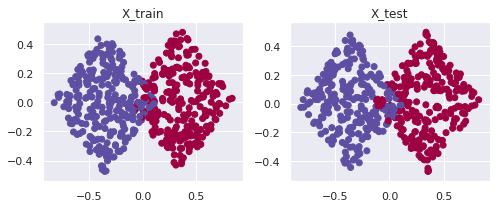

Classification KNN+ACP sans extra dimension : exactitude=0.958	F1=0.9579


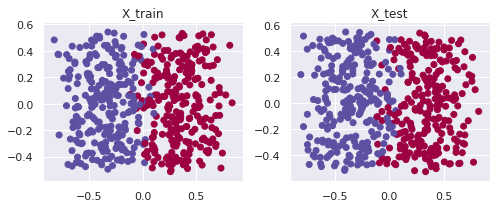

Classification KNN+ACP avec 1 extra dimensions aléatoires : exactitude=0.954	F1=0.9539


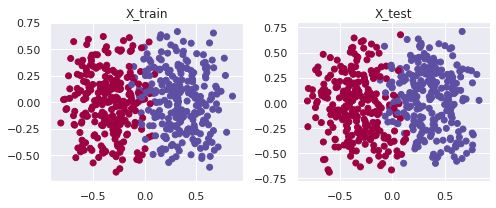

Classification KNN+ACP avec 2 extra dimensions aléatoires : exactitude=0.954	F1=0.9539


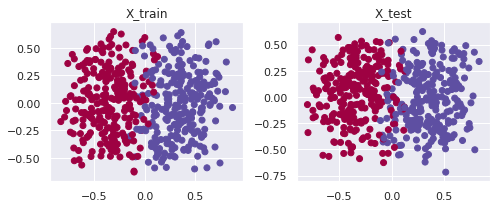

Classification KNN+ACP avec 3 extra dimensions aléatoires : exactitude=0.94	F1=0.9393


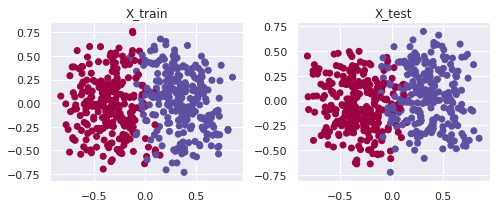

Classification KNN+ACP avec 4 extra dimensions aléatoires : exactitude=0.942	F1=0.9428


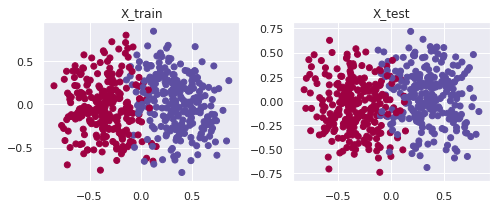

Classification KNN+ACP avec 5 extra dimensions aléatoires : exactitude=0.936	F1=0.9365


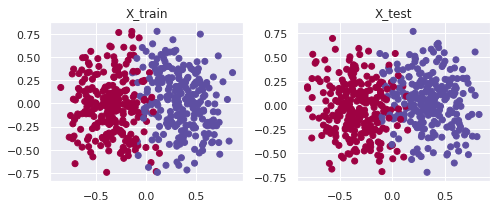

Classification KNN+ACP avec 6 extra dimensions aléatoires : exactitude=0.946	F1=0.9465


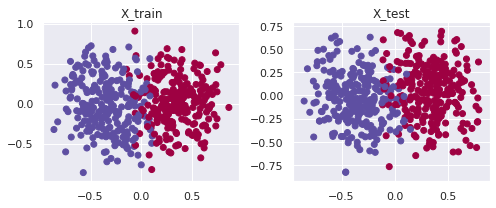

Classification KNN+ACP avec 7 extra dimensions aléatoires : exactitude=0.946	F1=0.9457


Classification KNN+ACP avec 8 extra dimensions aléatoires : exactitude=0.938	F1=0.9384


Classification KNN+ACP avec 9 extra dimensions aléatoires : exactitude=0.944	F1=0.9444


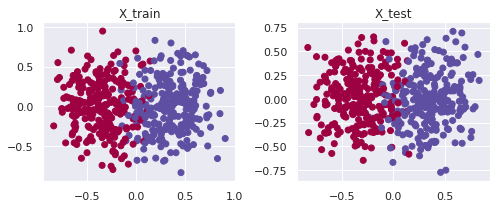

Classification KNN+ACP avec 10 extra dimensions aléatoires : exactitude=0.934	F1=0.9339


Classification KNN+ACP avec 11 extra dimensions aléatoires : exactitude=0.934	F1=0.9344


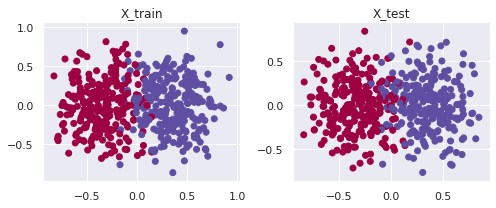

Classification KNN+ACP avec 12 extra dimensions aléatoires : exactitude=0.932	F1=0.9331


Classification KNN+ACP avec 13 extra dimensions aléatoires : exactitude=0.93	F1=0.9299


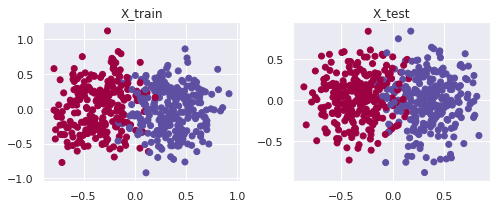

Classification KNN+ACP avec 14 extra dimensions aléatoires : exactitude=0.924	F1=0.9246


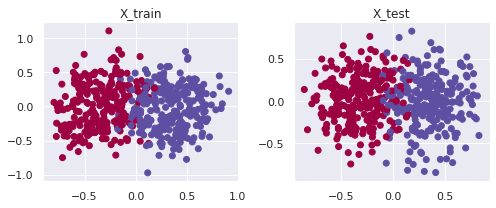

Classification KNN+ACP avec 15 extra dimensions aléatoires : exactitude=0.934	F1=0.9349


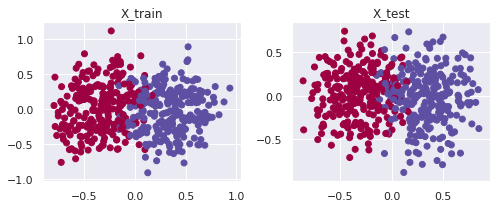

Classification KNN+ACP avec 16 extra dimensions aléatoires : exactitude=0.936	F1=0.9363


Classification KNN+ACP avec 17 extra dimensions aléatoires : exactitude=0.936	F1=0.9368


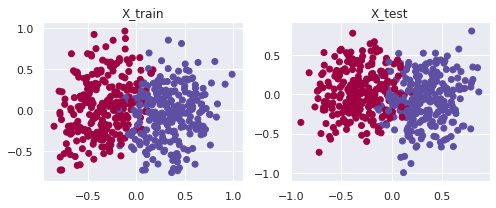

Classification KNN+ACP avec 18 extra dimensions aléatoires : exactitude=0.934	F1=0.9354


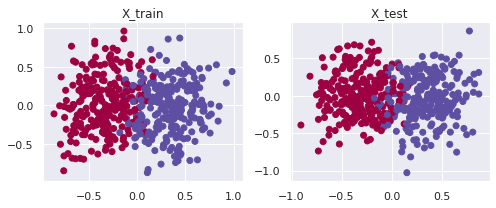

Classification KNN+ACP avec 19 extra dimensions aléatoires : exactitude=0.932	F1=0.9325


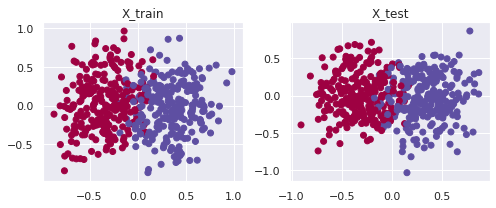

Classification KNN+ACP avec 20 extra dimensions aléatoires : exactitude=0.93	F1=0.9307


In [13]:
# Sans dimension additionelle
KNN_XX_acp = {0:clf_knn_acp(X_ExtraDim[0],y,True)}
print('Classification KNN+ACP sans extra dimension : exactitude='+str(KNN_XX_acp[0]['exactitude'])+'\tF1='+str(KNN_XX_acp[0]['F1']))
# En ajoutant de nouvelles dimensions ne contenant aucun signal de classification
for nd in range(1,maxExtraDim+1):
    KNN_XX_acp[nd] = clf_knn_acp(X_ExtraDim[nd],y,True)
    print('Classification KNN+ACP avec '+str(nd)+' extra dimensions aléatoires : exactitude='+str(KNN_XX_acp[nd]['exactitude'])+'\tF1='+str(KNN_XX_acp[nd]['F1']))

On observe dans tous les cas un séparation claire entre les patients des deux classes. 